Link: https://github.com/SnowWindSaveYou/UTS_ML2019_99151300/blob/master/A2_Report.ipynb
###### import required files and initial env

In [467]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.metrics import mean_squared_error
import warnings
import sys
import math
from imp import reload
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
from livelossplot import PlotLosses

# A2 codes
import A2_codes.data_formater as A2_formater
import A2_codes.useritem_loader as A2_dataloader
import A2_codes.similarity_model as A2_SIM
import A2_codes.matrix_factoriz as A2_MF


warnings.filterwarnings('ignore')
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device( "cpu")

# Movie Recommendation Models for Netflix Dataset



 Jingyi Wu 99151300

# Introduction


Along with the  network information rapid growth, the rich information caused the problem of information overload, the manifestation of it is people are hard to make decision on various items, and  an item will have less possibility meet by target user. An example of this consequence can be a good movie only have limited box office income because of no one heard about it. in this situation, a decision support system for recommend appropriate items to user are important, because of it can provide the chance of the item can contact  with the target user over huge information sea, that active the economic flows over internet and finally can benefits to the platform maintaining recommendation system.

In application, this problem can  transfer into the problem of predict the rating or ranking of the user would give to each item. because of the reliable application prospects and business values, there are various methods have designed for make recommendation. The major recommendation systems have two main ways, one is content based system that use the tags of items and historical preference of user to recommend the item have same tags as user browsed before, but those kind of system have the problem of over-specialization that can only find known preference while can't find potential preference, and easy to make other problem of information cocoon. (Adomavicius & Tuzhilin 2005) So, for solve the problem of information overload I think that collaborative filter based systems are more appropriated, those kind of methods make recommendation by sharing information between user or items, main idea of them are make recommendation by find other users have same preference. in this case, the machine learning technologies are also widely used in recommendation system, they are usually used for extract the features or modelling auxiliary information, but recent research also analysis how to use them to interact user and item features. (He et al. 2017)

Netflix price dataset is the dataset provided by Netflix company for movie recommendation. in this report I will analysis how to build the models over Netflix dataset, the objective is to learn the good recommendation by predict the rating of user would give to movies through collaborative filtering methods those sharing user and item features.

# Exploration

Netflix price dataset contains seven files include the ratings of users give to each movie with its date and the movie information include their publish date and name.  Since the initial format of dataset is not suitable for exploring, so my first step is to format it into tubule data for carry out subsequence of data mining and modelling works. 

In [3]:
df = pd.read_csv('./dataset/netflix-prize-data/combined_data_1.txt', 
                 header = None, names = ['user', 'rating','date'], 
                 usecols = [0,1,2])

In [138]:
movie_title_df = pd.read_csv('./dataset/netflix-prize-data/movie_titles.csv',
                             encoding = "ISO-8859-1",
                             header = None, names = ['movie','publish', 'title'], 
                             usecols = [0,1,2])

In [139]:
# the user id with empty rating and date is the movie id
df.head(5)

,user,rating,date
0,1:,NaN,NaN
1,1488844,3.0,2005-09-06
2,822109,5.0,2005-05-13
3,885013,4.0,2005-10-19
4,30878,4.0,2005-12-26


In [140]:
movie_title_df.head(5)

,movie,publish,title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [4]:
# slice movie by empty rows
sliced_df = A2_formater.slice_movie(df)

# format data type
sliced_df['date']= pd.to_datetime(sliced_df['date'])
sliced_df['rating']=sliced_df['rating'].astype(float)
sliced_df['movie']=sliced_df['movie'].astype(int)
sliced_df['user']=sliced_df['user'].astype(int)

In [6]:
movie_title_df['publish'][~(movie_title_df['publish'].isna())].mean()

In [ ]:
movie_title_df['movie']=movie_title_df['movie'].astype(int)
movie_title_df[movie_title_df['publish'].isna()] = movie_title_df['publish'][~(movie_title_df['publish'].isna())].mean() # fill missing
movie_title_df['publish']= pd.to_datetime(movie_title_df['publish'].astype(int), format ='%Y' )
combine_df = sliced_df.merge(movie_title_df[['publish','movie']],on='movie')
combine_df.head(5)

In [133]:
print("Data length: ",len(combine_df))

Data length:  24053764


After formatted dataset, we got 24053764 count of tabule data, and it contains five attributes: movie id, user id, rating of user give to movie, date of rating record, and movie publish year. in subsequence of this section will detaily explore each data, and identify the challenges on data.

------------------------
## Attributes
### user

- Type: Numeric categories

The id of users, after drop duplicates we can seen that dataset contains 470758 different users. most users are rated 10~50 movies, only few of them had rating over 2000 movies.

Length:  470758


{'whiskers': [<matplotlib.lines.Line2D at 0x2462b2ddeb8>,
 'caps': [<matplotlib.lines.Line2D at 0x2462b2e7588>,
 'boxes': [<matplotlib.lines.Line2D at 0x2462b2dda90>],
 'medians': [<matplotlib.lines.Line2D at 0x2462b2e7c18>],
 'fliers': [<matplotlib.lines.Line2D at 0x2462b2e7f60>],
 'means': []}

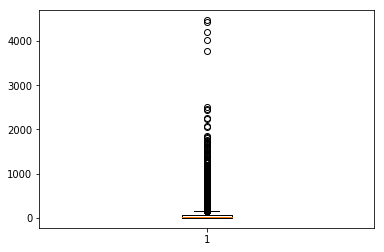

In [100]:
users_rating_count = sliced_df.groupby('user')['user'].agg(['count']).reset_index()
print("Length: ",len(users_rating_count))
plt.boxplot(users_rating_count['count'].astype(int))

         binned   count
0        (0, 1]   15225
1       (1, 10]  124902
2      (10, 50]  184967
3     (50, 100]   75394
4   (100, 1000]   70185
5  (1000, 2000]      73
6  (2000, 5000]      12


<BarContainer object of 7 artists>

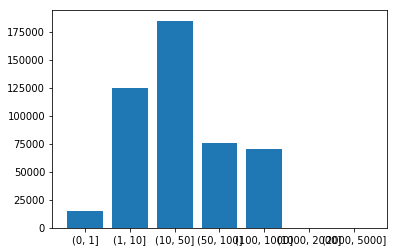

In [101]:
bins = [0,1,10,50,100,1000,2000,5000]
users_rating_count['binned'] = pd.cut(users_rating_count['count'], bins)
user_activity_bin = users_rating_count.groupby('binned')['binned'].agg(['count']).reset_index()
print(user_activity_bin)
plt.bar(user_activity_bin['binned'].astype(str),user_activity_bin['count'])

------------------------
### movie
- Type: Numeric categories

The id of movie,  after drop duplicates we can seen that dataset contains 4499 different movie. And this id is formated in a complete ordered sequence from 1 to 4499.And most movies have limite rating records.

Number of moves:  4499
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


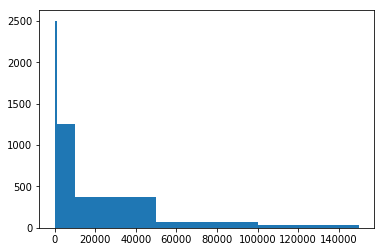

In [106]:
movie_popularity = sliced_df.groupby('movie')['movie'].agg(['count']).reset_index()
plt.hist(movie_popularity['count'],bins=[0,100,1000,10000,50000,100000,150000])
print("Number of moves: ",len(movie_popularity ))
print(list(movie_popularity['movie'][:100]))

------------------------
### rating
- Type: Numeric ordinal
- Value range: 1,2,3,4,5

The rating of user give to the movie, most values are around 4, and only few values are rating one. 

In [79]:
print("rating min: ",sliced_df['rating'].min()," max: ",sliced_df['rating'].max()," mode: ", sliced_df['rating'].mode())

rating min:  1.0  max:  5.0  mode:  0    4.0
dtype: float64


   rating    count
0     1.0  1118186
1     2.0  2439073
2     3.0  6904181
3     4.0  8085741
4     5.0  5506583


<BarContainer object of 5 artists>

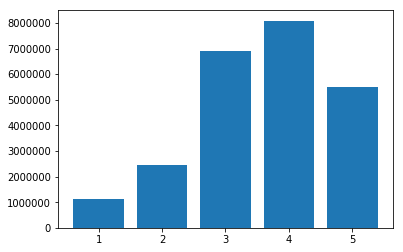

In [75]:
rating_distr = sliced_df.groupby('rating')['rating'].agg(['count']).reset_index()
print(rating_distr)
plt.bar(rating_distr["rating"],rating_distr["count"])

------------------------
### date
- Type: Ordinal Date
- Value range: 1999-11-11 ~ 2005-12-31

The timestamp of the user rating the movie. along with the time progresses, the rating data have rapid growth

In [80]:
print("date min: ",sliced_df['date'].min()," max: ",sliced_df['date'].max())

date min:  1999-11-11 00:00:00  max:  2005-12-31 00:00:00


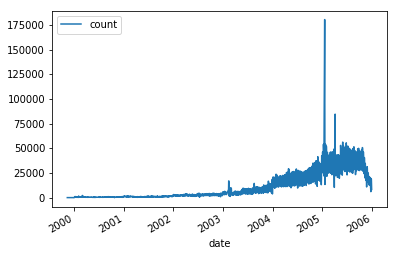

In [99]:
date_distr = sliced_df.groupby('date')['date'].agg(['count']).reset_index().set_index('date')
date_distr.plot()

------------------------
### publish
- Type: Ordinal Date
- Value range: 1915-01-01 ~ 2005-01-01

The movie publish time, it shows most movies in dataset are close to the time of dataset published, and new movies rapidly increase by year.

In [148]:
print("publish min: ",combine_df.min()," max: ",combine_df['publish'].max())

publish min:  1915-01-01 00:00:00  max:  2005-01-01 00:00:00


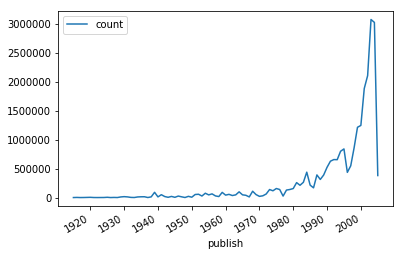

In [155]:
publish_distr = combine_df.groupby('publish')['publish'].agg(['count']).reset_index().set_index('publish')
publish_distr.plot()
plt.show()

------------------------
## Sparse  matrix

Overall, the user-movie rating data is an matrix like `[user ,[movie ,[rating, ]]]`, each row of it is represents a user, each column represents a movie, and the each corresponding element is represent the rating of user give to movie. Since that sparse matrix have a very high dimension due to large number of users and movies, it brings the of challenge on memory cost.

In [ ]:
## imposible to put all data into memoty by one matrix
# full_data_sprase_matrix = A2_formater.make_sprase_matrix(sliced_df[:],4499) # Memory Error

In [201]:
## so, just use part of data for explore the sparsity and calculate full cost
sparse_matrix = A2_formater.make_sparse_matrix(sliced_df[:4499],4499)
memory_cost = sys.getsizeof(sparse_matrix)
full_memory_cost = memory_cost/4499*len(sliced_df)
def byte_to_mb(b):
    return b / 1024/1024
print(sparse_matrix)
print("memory cost for 4499 x 4499 sparse matrix: %d byte = %d mb"%(memory_cost,byte_to_mb(memory_cost)))
print("memory cost for full data sparse matrix: %d byte = %d mb"%(full_memory_cost,byte_to_mb(full_memory_cost)))

[[3. 0. 0. ... 0. 0. 0.]
 [5. 0. 0. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
memory cost for 4499 x 4499 sparse matrix: 156889240 byte = 149 mb
memory cost for full data sparse matrix: 838803457012 byte = 799945 mb


while, althrough that matrix are very large, but due to the user is impossible to give all movie the rating, so the most location in that matrix are 0, which means its a sparse matrix,
by samples part of data for measure the sparsity of Netflix data, it shows 0.02% sparsity , which means 99.98% space in that matrix are 0.

In [202]:
sparsity = float(len(sprase_matrix.nonzero()[0]))
sparsity /= (sparse_matrix.shape[0] * sparse_matrix.shape[1])
sparsity *= 100
print ('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 0.02%


------------------------
## Clean and Dataset Design

Since the low activate users are useless for collaborative filtering based models, I filtered out the user have rated movies lower than 50. And for evaluate the models I will explain in next section, I decided to split the data set into three sets.

- Train: include most data except the data in test set.
- Test: randomly choose 1/10 users, and split their data by time '2005/12/1', so that dataset have include 1/10 users without data after '2005/12/1'.
- Target: target is the full data of test data, it include full data of 1/10 users chosen by test set

This split way allows me can evaluate the accuracy of model predict the rating of users would give to the items they were not seen before, at same time allows me can choose small or large amount of data to evaluate models.

In [54]:
users_df = A2_formater.get_users_df(sliced_df)

In [ ]:
# split data only by user id
# train_set, test_set = filter_data_by_user(sliced_df,users_df,frac=0.1,count=50)

In [ ]:
#split data by date and user id
train_set, test_set, target_set = A2_formater.filter_data_by_date(sliced_df,users_df)
target_set = target_set[target_set['user'].isin(test_set['user'])]

The user-item dataset is designed for models only control observe data, which can helps them to obtain stuctured user-item pair and corresponding rating.

In [78]:
# makeup data
total_ratings,user_item_pairs,ratings,num_users,num_items,user_lists = A2_dataloader.prepro(train_set)
total_ratings_test,user_item_pairs_test,ratings_test = A2_dataloader.prepro(test_set,user_lists)
# make dataset 
train_dataset = A2_dataloader.UserItemDataset(user_item_pairs,ratings)
test_dataset = A2_dataloader.UserItemDataset(user_item_pairs_test,ratings_test)

num_users:  145643 num_items:  4499


In [92]:
# make data loader
sample_params = {'batch_size': 1024,'shuffle': True,'num_workers': 0}
train_generator = torch.utils.data.DataLoader(train_dataset, **sample_params)
test_generator = torch.utils.data.DataLoader(test_dataset, **sample_params)
train_iter = iter(train_generator)
test_iter = iter(test_generator)

------------------------


# Methodology

in this section I will build and train some collaborative filtering based data models over structured Netflix dataset for learn recommendation. First I will build the user-based and item-based similarity models as a base line, and then introduce an build two different network based matrix factorization models.


## Item-based and User-based Similarity Models
As the fundamental of the collaborative filtering methods, the item-based and user-based similarity models can be the good baseline when evaluate other models. those two are both the memory based collaborative filtering methods, they are measure the similarity of users and items by cosine, Pearson or other correlation coefficient matric to make a matrix record the similarity between users or items.

since the memory based model requires very large memory space, i only use 5156 users\' data for make similarity matrix. 

In [444]:
# use small amount of data to make matrix
train_matrix = A2_formater.make_sparse_matrix(test_set,4499)
test_matrix = A2_formater.make_sparse_matrix(target_set,4499)
print("Train matrix:",train_matrix.shape)
print("Test matrix:",test_matrix.shape)

Train matrix: (5156, 4499)
Test matrix: (5156, 4499)


In [ ]:
def get_union(vector1,vector2):
    new_vector1 = vector1[(vector1!=0 )& (vector2 != 0)]
    new_vector2 = vector2[(vector1!=0 )& (vector2 != 0)]
    return new_vector1,new_vector2

Cosine Similarity:

$W_{u, v}=\frac{|N(u) \cap N(v)|}{\sqrt{|N(u)||N(v)|}}$

In [ ]:
def cosine_similarity(vector1, vector2):
    new_vector1, new_vector2 = get_union(vector1,vector2)
    if len(new_vector1)==0 or len(new_vector2)==0:
        return 0
    dot_product = (new_vector1*new_vector2).sum()
    normA = ((new_vector1)**2).sum()
    normB = ((new_vector2)**2).sum()
    return round(dot_product / ((normA**0.5)*(normB**0.5)), 2)

Pearson Correlation Coefficient: 

$r=\frac{\sum_{i=1}^{n}\left(X_{i}-\overline{X}\right)\left(Y_{i}-\overline{Y}\right)}{\sqrt{\sum_{i=1}^{n}\left(X_{i}-\overline{X}\right)^{2}} \sqrt{\sum_{i=1}^{n}\left(Y_{i}-\overline{Y}\right)^{2}}}$

In [452]:
def pearson_similarity(vector1, vector2):
    new_vector1, new_vector2 = get_union(vector1,vector2)
    if len(new_vector1)==0 or len(new_vector2)==0:
        return 0
    new_vector1_mean = new_vector1 - np.mean(new_vector1)
    new_vector2_mean = new_vector2 - np.mean(new_vector2)
    norm = np.linalg.norm(new_vector1_mean)*np.linalg.norm(new_vector2_mean)
    return np.dot(new_vector1_mean,new_vector2_mean)/norm

In [453]:
def user_sim(train_data_matrix, algo = "cosine"):
    user_similarity = np.zeros((train_data_matrix.shape[0], train_data_matrix.shape[0]))
    for i, cur in enumerate(user_similarity):
        for j,v in enumerate(cur):
            if user_similarity[i][j] == 0:
                if algo == "cosine":
                    user_similarity[i][j] = cosine_similarity(train_data_matrix[i], train_data_matrix[j])
                else:
                    user_similarity[i][j] = pearson_similarity(train_data_matrix[i], train_data_matrix[j])
                user_similarity[j][i] = user_similarity[i][j]
    return user_similarity

def item_sim(train_data_matrix, algo = "cosine"):
    train_data_matrix_t = train_data_matrix.T
    item_similarity = np.zeros((train_data_matrix.shape[1], train_data_matrix.shape[1]))
    for i, cur in enumerate(item_similarity):
        for j,v in enumerate(cur):
            if item_similarity[i][j] == 0:
                if algo == "cosine":
                    item_similarity[i][j] = cosine_similarity(train_data_matrix_t[i], train_data_matrix_t[j])
                else:
                    item_similarity[i][j] = pearson_similarity(train_data_matrix_t[i], train_data_matrix_t[j])
                item_similarity[j][i] = item_similarity[i][j]
    return item_similarity

In [450]:
user_similarity = A2_SIM.user_sim(train_matrix)

1.0 0.0
(5156, 5156)
[[1. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 1. 0.]
 [1. 1. 0. ... 0. 0. 1.]]


In [451]:
item_similarity = A2_SIM.item_sim(train_matrix)

1.0 0.0
(4499, 4499)
[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


------------------------

## Matrix Factorization

The traditional Matrix factorization algorithm is a well-known collaborative filtering algorithm using the latent factor model (LFM). The LFM is predict the rating of the user would give to the  item by characterizing both of them into their latent factor. through describe the attributes and preference of user and item into their factor matrix, the dot product of user and item factor matrix would be the predicted rating matrix.  following with this idea, the matrix factorization algorithm is a way of factorize the observed into user and item matrixes.
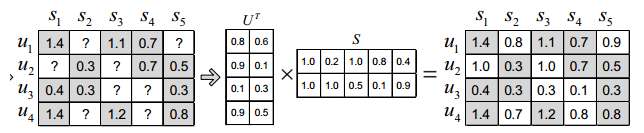


The traditional Matrix factorization algorithm are used gradient decent or alternating least squares methods to minimizing the dot product result observed data. since the final goal of the algorithm is to calculate the inner product, and its non-linear, so it seems that algorithm also can implement by neural network, and even get better performance. (gink, 2018) In this case, He et al. 2017 point out that traditional dot product have limited the expression ability of MF, but through repeat it by neural network can solve that problem.

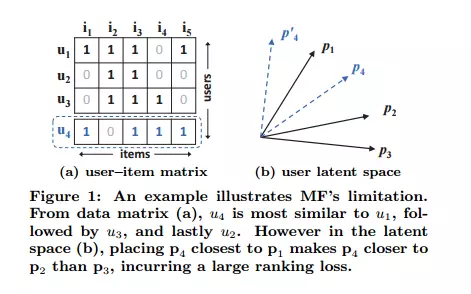


In [471]:
class MF(torch.nn.Module):
    def __init__(self, num_users, num_items,latent_dim=8,h = 512):
        super(MF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.latent_dim = latent_dim
        self.h = h

        self.embedding_user = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim,sparse=True)
        self.embedding_item = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim,sparse=True)
        self.user_fc = nn.Linear(in_features=self.latent_dim, out_features=self.h, bias=True)
        self.item_fc = nn.Linear(in_features=self.latent_dim, out_features=self.h, bias=True)
    
        self.fc = nn.Linear(in_features=self.h, out_features=1, bias=True)
    
        
    def forward(self, user_indices, item_indices):
        user_embedding = F.relu(self.user_fc(self.embedding_user(user_indices)))
        item_embedding = F.relu(self.item_fc(self.embedding_item(item_indices)))
        
        return F.relu(self.fc(user_embedding * item_embedding))

In [329]:
class MLP(torch.nn.Module):
    def __init__(self, num_users, num_items,latent_dim=8,layers = [16,32,16,8]):
        super(MLP, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.latent_dim = latent_dim

        self.embedding_user = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim)
        self.embedding_item = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim)

        self.fc_layers = torch.nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(layers[:-1], layers[1:])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))
        self.affine_output = torch.nn.Linear(in_features=layers[-1], out_features=1)
        
    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        
        vector = torch.cat([user_embedding, item_embedding], dim=-1)
        for idx, _ in enumerate(range(len(self.fc_layers))):
            vector = self.fc_layers[idx](vector)
            vector = torch.nn.ReLU()(vector)
            
        out = self.affine_output(vector)
        return out


In [341]:
# Basic MF model
MF_model = MF(num_users+1,num_items+1).to(device)
MF_opt = optim.SGD(MF_model.parameters(), lr=0.001)
MF_criterion = torch.nn.MSELoss()

In [342]:
# MLP based model
MLP_model = MLP(num_users+1,num_items+1).to(device)
MLP_opt = optim.SGD(MLP_model.parameters(), lr=0.001)
MLP_criterion = torch.nn.MSELoss()

In [343]:
# eval data
testab = test_iter.next()

In [369]:
testab[0]

tensor([[ 19301,   3579,      0,  ...,      0,      0,      0],
        [ 99686,    528,      0,  ...,      0,      0,      0],
        [103430,   3451,      0,  ...,      0,      0,      0],
        ...,
        [ 15362,   2391,      0,  ...,      0,      0,      0],
        [100565,    872,      0,  ...,      0,      0,      0],
        [ 49296,   3860,      0,  ...,      0,      0,      0]],
       dtype=torch.int32)

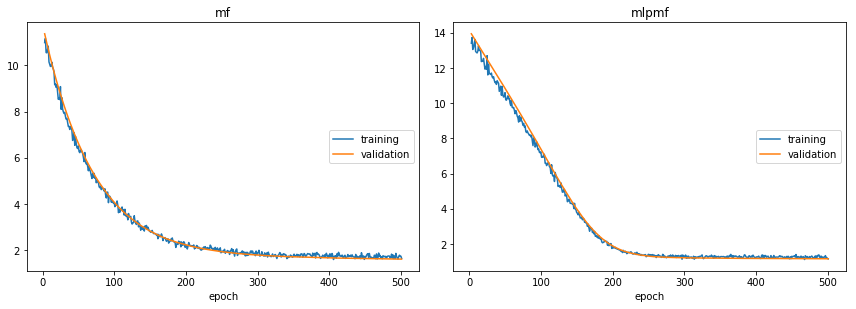

mf:
training   (min:    1.595, max:   11.169, cur:    1.647)
validation (min:    1.612, max:   11.645, cur:    1.612)

mlpmf:
training   (min:    1.120, max:   13.726, cur:    1.157)
validation (min:    1.164, max:   14.069, cur:    1.164)


In [348]:
liveloss = PlotLosses()
mftrain,mlptrain, = A2_MF.epoch_run_2(MF_model,MLP_model, train_generator, testab, MF_opt, MLP_opt,MF_criterion,MLP_criterion,liveloss)

------------------------



# Evaluation

Since the recommendation system are predict the unknown knowledge, its impossible to makeup data and hard for individual researcher to test models in actual environment, the evaluation of recommendation system become an challenge. if is an enterprise developer, the best way is to develop the model online and to check the metrics of recall rate and do A/B test. But since the online evaluation methods are impossible for individual, in this report I'm only use the off-line evaluation methods such as the accuracy, memory cost, effecency and coverage.

- Accuracy: how accurate is the predicted rating?
- Memory cost: how much memory it will cost, would it cause the problem on application?
- Effecency: how long is the time it takes for responding user?
- Coverage: how much items it can cover for mining user potential interest?

### Accuracy Metrics
the accuracy is an important matric for measure the correctness of system predict the rating of user would give to items. similar with the regression problem, the main matrices of it are MAE and RMSE.

####    Root mean squared error
 $\operatorname { RMSE } =  { \sqrt{ \frac{1}{|\mathcal{T}|}{ \sum _ { ( u , i ) \in T } \left( r _ { u i } - \hat { r } _ { u i } \right) ^ { 2 } } }} $

In [463]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return math.sqrt(mean_squared_error(prediction, ground_truth))

####   Mean absolute error
$\mathrm{MAE}=\frac{1}{|\mathcal{T}|} \sum_{(u, i) \in \mathcal{T}}\left|\hat{r}_{u i}-r_{u i}\right|$

In [351]:
def mae(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    absError = abs(prediction - ground_truth)
    return sum(absError) / len(absError)

### Item-based and User-based model

By measure the MAE and RMSE, the item based is obviously accurate than user based, while the user-based model have covered more items to recommend. And the prediction time and the training time  of item-based model are also obviously longer than user based, however this calculation time cost is depend on the number of users and items, if I got the relatively lower number of items, the item based model would be better choose, vice versa.

In [458]:
memory_cost = sys.getsizeof(user_similarity)
print("memory cost for 5156 x 5156 user matrix: %d byte = %d mb"%(memory_cost,byte_to_mb(memory_cost)))
memory_cost = sys.getsizeof(item_similarity)
print("memory cost for 4499 x 4499 movie matrix: %d byte = %d mb"%(memory_cost,byte_to_mb(memory_cost)))

memory cost for 5156 x 5156 user matrix: 212674800 byte = 202 mb
memory cost for 4499 x 4499 movie matrix: 161928120 byte = 154 mb


##### user based

In [499]:
%time user_pred = A2_SIM.predict_user(test_matrix, user_similarity)
user_pred_t = A2_SIM.predict_user(train_matrix, user_similarity)

Wall time: 4.19 s


In [478]:
user_rmse = rmse(user_pred, test_matrix) 
user_mae = mae(user_pred, test_matrix) 
print("part user-base model RMSE : %.3f"%(user_rmse))
print("part user-base model MAE : %.3f"%(user_mae))
user_rmse = rmse(user_pred_t, test_matrix) 
user_mae = mae(user_pred_t, test_matrix) 
print("all user-base model RMSE : %.3f"%(user_rmse))
print("all user-base model MAE : %.3f"%(user_mae))

part user-base model RMSE : 2.682
part user-base model MAE : 2.394
all user-base model RMSE : 3.576
all user-base model MAE : 3.410


In [510]:
print("coverage:", len(user_pred[user_pred>4]))

coverage: 5311


##### item based

In [500]:
%time item_pred = A2_SIM.predict_item(test_matrix, item_similarity)
item_pred_t = A2_SIM.predict_item(train_matrix, item_similarity)

Wall time: 5.01 s


In [495]:
item_rmse = rmse(item_pred, test_matrix) 
item_mae = mae(item_pred, test_matrix) 
print("part user-base model RMSE : %.3f"%(item_rmse))
print("part user-base model MAE : %.3f"%(item_mae))
item_rmse = rmse(item_pred_t, test_matrix) 
item_mae = mae(item_pred_t, test_matrix) 
print("all user-base model RMSE : %.3f"%(item_rmse))
print("all user-base model MAE : %.3f"%(item_mae))

part user-base model RMSE : 3.055
part user-base model MAE : 2.831
all user-base model RMSE : 3.692
all user-base model MAE : 3.532


In [509]:
print("coverage:", len(item_pred[item_pred>4]))

coverage: 735


### Matrix Factorization

By measure them with MAE and RMSE metrics, they have obviously high accuracy than baseline item and user based memory model, the MLP based model is more accurate than simple repeat dot product with neural network, however later has higher coverage which is better for mining potential user interesting even its usually are opposite to accuracy. They also got very shot prediction time in the 'ms' metric, and since the neural network is an O(1) algorithm, so their prediction time will not increase with the user or item increase.  and since the input of matix factorization is the id of users and items, that have the limitation of not allows to predict new user's data, and each time add new users or items it must redo once.

##### MLP MF

In [501]:
%time mlp_preds,mlp_labels, mlp_pairs = A2_MF.predict(MLP_model, test_generator)  
mlp_preds = mlp_preds.view(1, mlp_preds.size()[0]).to("cpu").numpy()[0]
mlp_labels = mlp_labels.view(1, mlp_labels.size()[0]).to("cpu").numpy()[0]

Wall time: 559 ms


In [493]:
mlp_rmse = rmse(mlp_preds, mlp_labels)
mlp_mae = mae(mlp_preds, mlp_labels) 
print("part user-base model RMSE : %.3f"%(mlp_rmse))
print("part user-base model MAE : %.3f"%(mlp_mae))

part user-base model RMSE : 1.092
part user-base model MAE : 0.892


In [511]:
print("coverage:", len(mlp_preds[mlp_preds>4]))

coverage: 2445


##### MF

In [502]:
%time mf_preds,mf_labels, mf_pairs = A2_MF.predict(MF_model, test_generator)  
mf_preds = mf_preds.view(1, mf_preds.size()[0]).to("cpu").numpy()[0]
mf_labels = mf_labels.view(1, mf_labels.size()[0]).to("cpu").numpy()[0]

Wall time: 670 ms


In [498]:
mf_rmse = rmse(mf_preds, mf_labels)
mf_mae = mae(mf_preds, mf_labels) 
print("part user-base model RMSE : %.3f"%(mf_rmse))
print("part user-base model MAE : %.3f"%(mf_mae))

part user-base model RMSE : 1.293
part user-base model MAE : 1.050


In [512]:
print("coverage:", len(mf_preds[mf_preds>4]))

coverage: 5232


------------------------


# Ethical

The ethical issue is an important consideration for the technologies, The main ethical issues of recommendation system are mainly located as spread bad information and invasion of privacy. to stat with discuss those ethical issue in recommendation system, first thing to do is to briefly identifier the stakeholders and their perspectives with the consideration of those ethic issues.

- user: care about self privacy, want to see interesting information but not proactive want.
- provider: want learn benefits, sale their product to users. want their items can observed by target users.
- platform: want learn benefits and their benefits are create by users and provider. want user stickiness.
- government: want the stable and active society, disgust with bad information. less interesting with highest power.

By sort out those stakeholders, its easier to see that main beneficiary are provider and platform, and user also have benefit from it. so, I can determine that develop a recommendation system are right for enterprises by both of utilitarian and duty based ethical approaches.  In the duty based approach the objective of enterprise or employees are make the prise, while in utilitarian approach spend less prise to got more benefits to the society also is right thing, that recommendation system can active the online economic flows and leads the benefits to all user, platform and producer.

Even so, those ethical issues still are the problem must be consider with, because of spread bad information will make the society not stable and leads the government dissatisfied, also the dissatisfaction from user also is bad for any enterprises.  those issues are challenge to solve, my suggestions are the enterprise must improve their self-management don't torch the bottom line.







# Conclusion

overall report, I have build four models for predict the rating of users would give to movies for make the recommendation system, and that system are solved the problem of information overload on internet, and also provides the benefits of active economical flows. as each models have their own limitation and the benefits, those system actually can collaborative together to make better prediction, for example the matrix factorization model not allowed to predict new users, but one way to solve it is to calculate the similarity of this new user with other, than use the similar user's data for make prediction.


# Rererence

He, X., Liao, L., Zhang, H., Nie, L., Hu, X. & Chua, T.-S. 2017, 'Neural collaborative filtering', International World Wide Web Conferences Steering Committee, pp. 173-82.

Isinkaye, F., Folajimi, Y. & Ojokoh, B. 2015, 'Recommendation systems: Principles, methods and evaluation', *Egyptian Informatics Journal*, vol. 16, no. 3, pp. 261-73.

Koren, Y., Bell, R. & Volinsky, C. 2009, 'Matrix factorization techniques for recommender systems', Computer, no. 8, pp. 30-7.

Salakhutdinov, R., Mnih, A. & Hinton, G. 2007, 'Restricted Boltzmann machines for collaborative filtering', *ACM*, pp. 791-8.

Su, X. & Khoshgoftaar, T.M. 2009, 'A survey of collaborative filtering techniques', *Advances in artificial intelligence*, vol. 2009.

Adomavicius, G. & Tuzhilin, A. 2005, 'Toward the next generation of recommender systems: A survey of the state-of-the-art and possible extensions', *IEEE Transactions on Knowledge & Data Engineering*, no. 6, pp. 734-49.


# Appendix

Load and format data: https://github.com/SnowWindSaveYou/UTS_ML2019_99151300/blob/master/A2%20Data%20__init__.ipynb

Explore data: https://github.com/SnowWindSaveYou/UTS_ML2019_99151300/blob/master/A2_exploration_and_modeling.ipynb

Similarity models: https://github.com/SnowWindSaveYou/UTS_ML2019_99151300/blob/master/sim.ipynb

RBM: https://github.com/SnowWindSaveYou/UTS_ML2019_99151300/blob/master/RBM.ipynb

MF: https://github.com/SnowWindSaveYou/UTS_ML2019_99151300/blob/master/MF.ipynb

KNN and SVD: https://github.com/SnowWindSaveYou/UTS_ML2019_99151300/blob/master/KNNandSVD.ipynb

##### RBM
The autoencoder witch can encode user rating list into hidden factor, then encode to the predicted rating list
it allows to put any new users to make encode and decode

In [513]:
class RBM():
    def __init__(self,
                 n_vis=4499,
                 n_hin=100,
                 k=5,
                 state = "train",
                 use_gpu=False
                ):
        self.desc = "RBM"
        self.W = torch.randn(n_hin,n_vis)*1e-2
        self.v_bias = torch.rand(1, n_vis)
        self.h_bias = torch.rand(1 ,n_hin)
        self.k = k
        self.state = state
        self.use_gpu = use_gpu
        if self.use_gpu:
            self.W = self.W.cuda()
            self.h_bias = self.h_bias.cuda()
            self.v_bias = self.v_bias.cuda()
    
    def v_to_h(self,v):
        v_activation = F.linear(v,self.W,self.h_bias)
        p_h = F.softmax(v_activation,dim=1)
        sample_h = torch.bernoulli(p_h)
        return p_h, sample_h
    
    def h_to_v(self,h):
        h_activation = F.linear(h,self.W.t(),self.v_bias)
        p_v = F.sigmoid(h_activation)
        sample_v = torch.bernoulli(p_v)
        return p_v, sample_v
        
    def forward(self,v):
        # Positive phase
        pre_h1,_ = self.v_to_h(v)
        # Negative phase; gibbs
        for k in range(self.k):
            _,hk = self.v_to_h(v)
            _,vk = self.h_to_v(hk)
            if self.state =="train":
                # mask
                vk[v <0] = v[v<0]
        pre_hk,_ = self.v_to_h(vk)
        return vk,pre_h1,pre_hk
    
    def learn(self, v, vk, ph, phk):
        # positive associations - negative associations
        a = torch.matmul(v.t(), ph) - torch.matmul(vk.t(), phk)
        self.W += a.t()
        # input_data - negative_visible_probabilities
        self.v_bias += torch.sum((v - vk), 0)
        # positive_hidden_probabilities - negative_hidden_probabilities
        self.h_bias += torch.sum((ph - phk), 0)
    def train(self):
        self.state = "train"
    def val(self):
        self.state = "val"
    def save_model(self,dir_name):
        opt = {
            "W":self.W,
            "v_bias":self.v_bias,
            "h_bias":self.h_bias,
            "k":self.k
        }
        torch.save(opt,dir_name)
        pass
    def load_model(self,dir_name):
        opt = torch.load(dir_name)
        opt['W'] = self.W
        opt['v_bias'] = self.v_bias
        opt['h_bias'] = self.h_bias
        opt['k'] = self.k
